# Wine Machine Learning

As someone whose hobbies include going out to bars with friends, I wanted to combine my hobbies with my passion for data science. Hence, I worked on a beer classification project for my PSTAT 135 class using machine learning algorithms and user reviews. While working on that project and getting fascinating results, I was curious if the same could be done for wine. After some time on Kaggle, I found a dataset that would allow me to do that: https://www.kaggle.com/zynicide/wine-reviews. 

The dataset contains text and numeric reviews about the thousands of different wines, which also includes its price, origin, etc. Before I could attempt to build a final model, I wanted to implement other data science techniques that we didn't include in class and answer some of the questions that I had.
 
 - How do I handle missing values in the dataset?
 - Which method is better for classification: only text, only numeric, or both types of columns?
 - Will results from topic modeling perform better than term document matrix?
 - How does class imbalance in the dataset impact my model?

Once I've answered the following questions to see which methods would improve modeling, then I could test out numerous methods to see which model performs the best in predicting the variety of wine given the data.

### Data Understanding

In [1]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from nltk.stem import PorterStemmer
from sklearn.feature_extraction import stop_words
from wordcloud import WordCloud
import warnings
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.decomposition import NMF
from imblearn.over_sampling import SMOTE
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.metrics import f1_score
warnings.filterwarnings('ignore')

In [2]:
# Importing the dataset
wine = pd.read_csv('wine.csv')

Before we can start any modeling or answer the questions we have above, we first need to understand our data better and know what we're dealing with.

In [3]:
# Dimensions of wine
wine.shape

(129971, 14)

In [4]:
# First five values of wine dataset
wine.head(5)

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


I will be deleting the following columns:

 - **Unnamed:** This columns is just an ordered list of the index of each row
 - **taster_twitter_handle:** I would rather use the actual name of the taster rather than their twitter handle
 - **region_2:** Based on the description of this column on Kaggle, there will be a lot of empty values and I would rather just keep country, province, and region_1 if we could.

In [5]:
# Dropping unimportant columns
wine.drop(['Unnamed: 0', 'taster_twitter_handle', 'region_2'], axis = 1, inplace = True)

Since we're interested in predicting the variety of wine, then I'll be looking at the variety column.

In [6]:
# Number of unique varieties of wine found in dataset
len(wine.variety.unique())

708

In [7]:
# Most prominent types of variety
wine.variety.value_counts().head(10)

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Riesling                     5189
Sauvignon Blanc              4967
Syrah                        4142
Rosé                         3564
Merlot                       3102
Name: variety, dtype: int64

Since there are 708 types of wine found in the dataset, it would create a lot of problems for us to attempt to classify all of the wines. Hence, I will only be classifying a few. Due to the top five most reviewed varieties having a lot more reviews than the rest, I decided to limit myself to predicting the following varieties: 
  
  - **Pinot Noir:** red wine grape variety created from pinot noir grapes with a relatively stronger flavor and lighter color
  - **Chardonnay:** white wine grape variety
  - **Cabernet Sauvignon:** red wine grape variety that are more thick and darker compared to its red wine grape variety
  - **Red Blend:** a blend of other red wine grape varieties
  - **Bordeaux-style Red Blend:** similar to red blend but grapes are limited to Bordeaux region

In [8]:
# Getting the top five most prominent types of variety
top5 = wine[wine.variety.isin(['Pinot Noir', 'Chardonnay', 'Cabernet Sauvignon', 'Red Blend',
                              'Bordeaux-style Red Blend'])]

# Dimensions of top 5 dataset
top5.shape

(50358, 11)

In [9]:
# Number of missing values per column
top5.isnull().sum(axis = 0)

country           19
description        0
designation    15710
points             0
price           3289
province          19
region_1        4528
taster_name    11326
title              0
variety            0
winery             0
dtype: int64

In [10]:
# Seeing how many unique values are there for categorical columns
number_uniqueDict = {}

for col in ['country', 'designation', 'region_1', 'taster_name', 'province', 'winery']:
    number_uniqueDict[col] = len(top5[col].unique())
    
number_uniqueDict

{'country': 37,
 'designation': 15006,
 'region_1': 801,
 'taster_name': 20,
 'province': 291,
 'winery': 9911}

In [11]:
# Getting the stats for wineries that appear less than 15 times to see if I could just group them together
less15 = top5['winery'].value_counts()[top5['winery'].value_counts() <= 15].index
print("The mean points for wineries that appear <= fifteen times,", top5[top5['winery'].isin(less15)]['points'].mean())
print("The mean price for wineries that appear <= fifteen times,", top5[top5['winery'].isin(less15)]['price'].mean())

The mean points for wineries that appear <= fifteen times, 88.27822490140123
The mean price for wineries that appear <= fifteen times, 37.71156810538117


As you can see above, there are six columns that have at least one null value and at most one column has roughly 28% null values. Due to the large amount of unique values in some of the columns, it also makes it hard to perform any KNN imputation. Also, I want to keep as much of the rows as possible as removing many rows might increase our bias and risk us of losing valuable information. Therefore, my plan is imputation as many values as possible.

Regarding the column 'country' and 'province', I will just remove those rows with missing values since there's only 19 of them. I'll be removing the column 'designation' as there are too many null values and unique values, which makes it difficult to impute. Also, there are some countries that don't have a region_1 value at all, making it very hard to impute.Therefore, the non-text columns I plan on using for modeling are 'taster_name','price', 'country', 'province', and 'points'.

Because of the large number of unique values of winery and the relatively low mean of points and price of wineries that don't appear often, I will be classifying them as "Other" to minimize the number of unique values.

In [12]:
# Removing rows with empty province/country
top5 = top5[top5['country'].notnull()]

In [13]:
# Removing columns that I will not be using for modeling
top5 = top5.drop(columns = ['designation', 'title', 'region_1'])

In [14]:
# Imputing Other to low level wineries
top5.loc[top5['winery'].isin(less15), 'winery'] = 'Other'

### Handling Text Data

I will be doing basic text preprocessing procedures:

 - Converting text to all lowercase to homogenize everything
 - Removing punctuation or any other unneccessary characters
 - Removing stop words to remove words that don't add any information
 - Stemming to make everything to its base form
 
Note that I added the words from the varieties I'm classifying because I want to make sure that I'm only looking at the features of the wine like its taste or appearance when classifying.

In [15]:
# Converting the text data to all lowercase
top5['description'] = top5['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Removing punctuation
top5['description'] = top5['description'].str.replace('[^\w\s]','')

# Removing stop words
stopWords = list(stop_words.ENGLISH_STOP_WORDS)
for word in ['pinot', 'noir', 'chardonnay', 'cabernet', 'bordeaux', 'blend', 'wine', 'sauvignon']:
    stopWords.append(word)
top5['description'] = top5['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stopWords))

# Stemming
st = PorterStemmer()
top5['description'] = top5['description'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
top5['description'].head()

4     like regular bottl 2012 come rough tannic rust...
10    soft suppl plum envelop oaki structur support ...
12    slightli reduc offer chalki tannic backbon jui...
14    build 150 year gener winemak tradit wineri tre...
20    ripe aroma dark berri mingl ampl note black pe...
Name: description, dtype: object

### Exploratory Analysis

The reason we would do exploratory analysis is to gain more insight about our data and potentially help improve our modeling.

([<matplotlib.patches.Wedge at 0x1eca66a1630>,
 [Text(0.743903,0.810314,'Pinot Noir'),
  Text(-0.803291,0.751481,'Chardonnay'),
  Text(-0.924768,-0.595655,'Cabernet Sauvignon'),
  Text(0.164449,-1.08764,'Red Blend'),
  Text(0.999147,-0.460113,'Bordeaux-style Red Blend')])

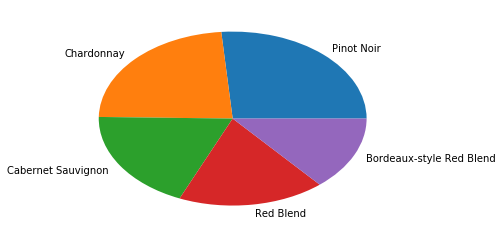

In [16]:
import matplotlib.pyplot as plt

sums = top5['variety'].value_counts()
plt.pie(sums, labels=sums.index)

#### Text

In [17]:
# Function based on Term Document Matrix (not focusing on weights/importance)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=1
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()
    
### I got this code from https://stackoverflow.com/questions/16645799/how-to-create-a-word-cloud-from-a-corpus-in-python

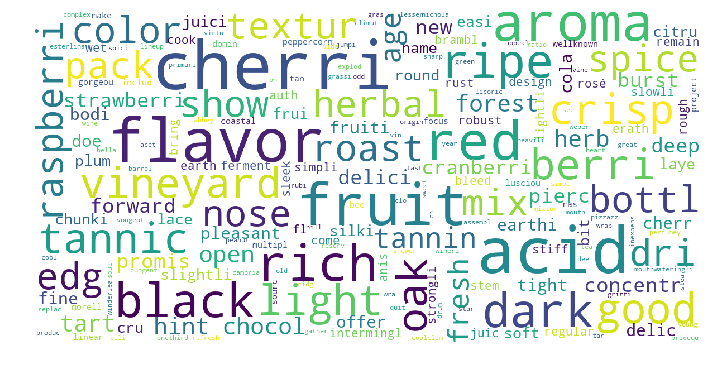

In [18]:
# Word Cloud for Pinot Noir
show_wordcloud(top5[top5['variety'] == 'Pinot Noir']['description'])

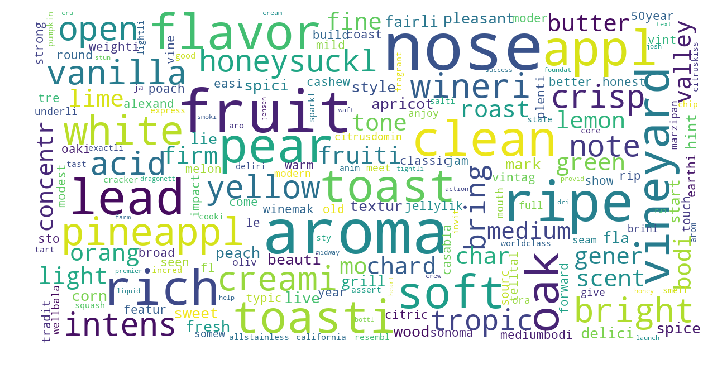

In [19]:
# Word Cloud for Chardonnay
show_wordcloud(top5[top5['variety'] == 'Chardonnay']['description'])

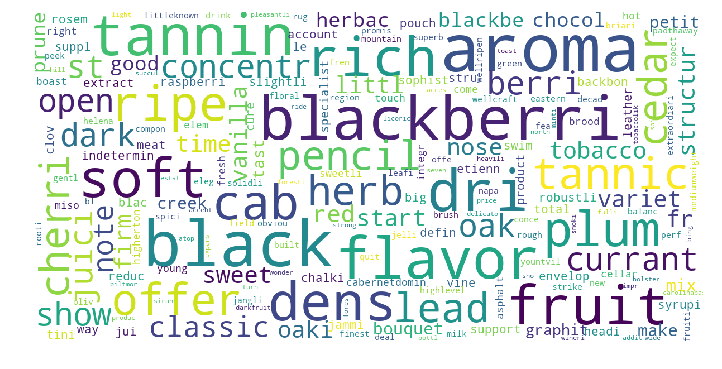

In [20]:
# Word Cloud for Cabernet Sauvignon
show_wordcloud(top5[top5['variety'] == 'Cabernet Sauvignon']['description'])

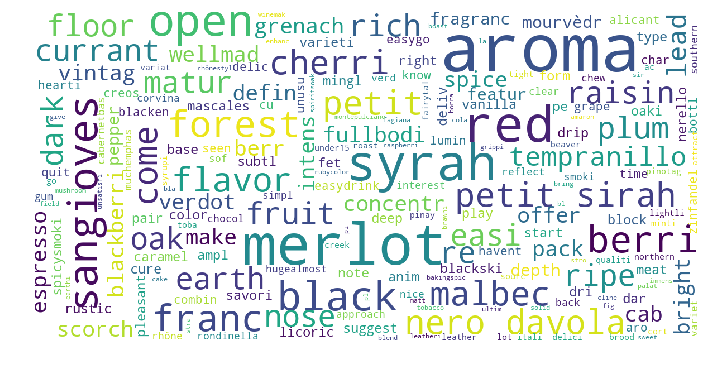

In [21]:
# Word Cloud for Red Blend
show_wordcloud(top5[top5['variety'] == 'Red Blend']['description'])

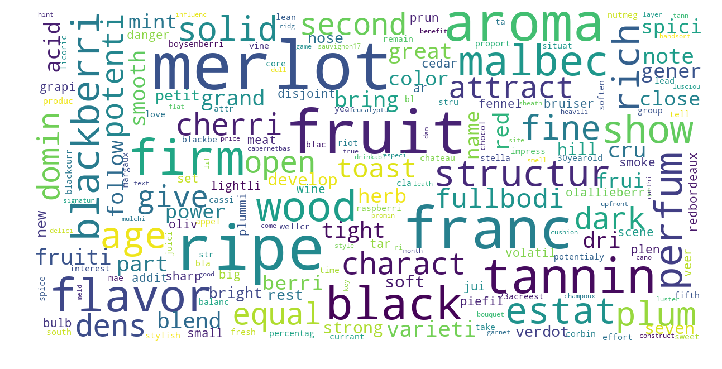

In [22]:
# Word Cloud for Bordeaux-style Red Blend 
show_wordcloud(top5[top5['variety'] == 'Bordeaux-style Red Blend']['description'])

Typically, word clouds would be very useful in adding more stop words regarding the topic I'm dealing with. For example in my beer project, I had to add useless words like "beer", "pour", and "brew" as these words do not help us differentiate the type of beer. However, due to my lack of knowledge about wine, it's hard to tell what words here are useless. 

Still, the word clouds I made are still interesting and showcase the differences of features between the five varieties. For example, it seems like the main fruit used for Cabernet Sauvignon is blackberries while we see pears and pineapple appear more often in Chardonnay. I hope that these types of words will provide a better indication of what variety it is given the text review for our model.

#### Numerical Columns

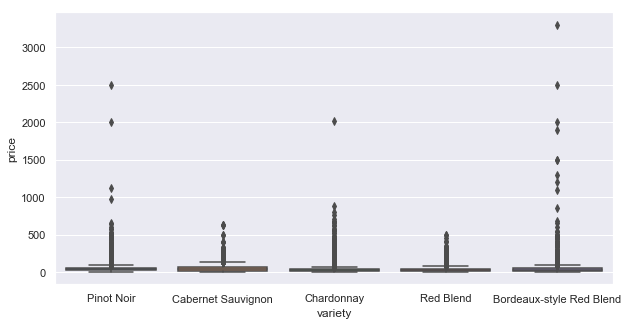

In [23]:
# Boxplot (Price w/ outliers)
sns.set(rc={'figure.figsize':(10,5)})

sns.boxplot(x = "variety", y = "price", data = top5)

[(0, 100)]

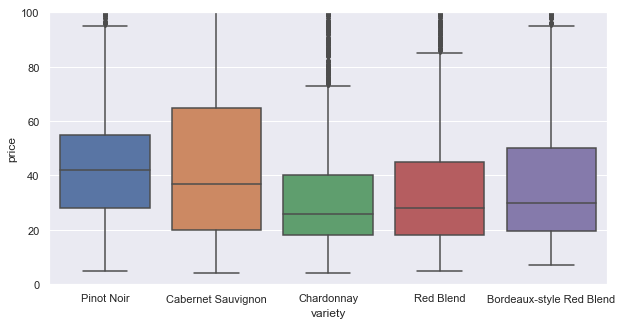

In [24]:
# Boxplot (Price w/ outliers)
plot = sns.boxplot(x = "variety", y = "price", data = top5)
plot.set(ylim=(0, 100))

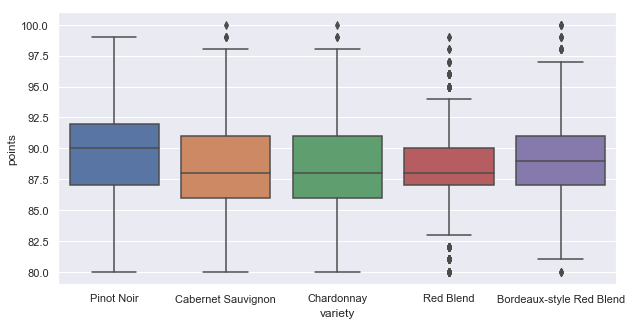

In [25]:
# Boxplot (Points w/ outliers)
sns.boxplot(x = "variety", y = "points", data = top5)

From looking at the box plots, we can see that there might be a relationship between price and points since Pinor Noir and Bordeaux-style Red Blend have among the highest points and price. Also, these two varieties have the most outliers for price. This makes sense since more expensive wine should be better than cheaper wine. I'm hoping that these differences could improve our model.

### Handling Other Columns (Imputation)

In [26]:
# Getting the mode for taster name for each province and replacing it with the mode
for province in list(top5['province'].unique()):
    try:
        mode_reviewer = top5[(top5['province'] == province)]['taster_name'].value_counts().index[0] # Mode reviewer
        condition = (top5['province'] == province) & (top5['taster_name'].isnull())

        top5.loc[condition,'taster_name'] = mode_reviewer
        
    except:
        continue
        
# Check how many remaining null values in this column
top5['taster_name'].isnull().sum(axis = 0)

3

The reason there are 3 null values in 'taster_name' column is due to these provinces just not having a single reviewer name. Because of the low number of null values, I decided to just remove it so I didn't have to do any further research about who reviewed it on the internet.

In [27]:
# Removing the three null values mentioned above
top5 = top5[top5['taster_name'].isnull() == False]

In [28]:
# Finding the mean price of wine created in a country and imputing that value 
for country in top5['country'].unique():
    try:
        price_country = top5[top5['country'] == country]['price'].mean() # Mean price in that country
        condition = (top5['country'] == country) & (top5['price'].isnull())

        top5.loc[condition,'price'] = price_country
        
    except:
        continue

In [29]:
# Number of missing values per column
top5.isnull().sum(axis = 0)

country        0
description    0
points         0
price          0
province       0
taster_name    0
variety        0
winery         0
dtype: int64

### Comparing Text vs Other Columns vs Ensemble

I want to run some basic models using Naive Bayes and Logistic Regression (these models run very fast compared to other models) to compare the impact of the text reviews and other categorical/numerical columns. I would expect that the ensemble model (using all of the columns) would be the best since the model would be using a lot of information to differentiate the types of wine. Also, the addition of a few more columns shouldn't negatively impact our model against the curse of dimensionality. I think that using only text features would perform the second best since the word clouds that I made highlights clear differences between the varieties while the other columns has less variation among the types.

#### Text

Before we can run any modeling, we need to make sure that our input are all numbers as machines don't understand the meaning of strings. Therefore, we have to convert the response variable into numbers and then create a term document matrix.

In [30]:
# Converting variety column to categorical
top5['variety'] = top5['variety'].astype('category')
top5['variety'] = top5['variety'].cat.codes

# Create X and Y/Split dataset into 80/20
X = top5['description']
y = np.asarray(top5['variety'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Converting body column to TDM 
vectorizer = CountVectorizer(min_df = 5, max_df=0.95)  
vectorizer.fit(X_train)

# Transforming sets into TDM
X_trainTDM =  vectorizer.transform(X_train)
X_testTDM =  vectorizer.transform(X_test)

In [31]:
# Logistic Regression
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_trainTDM, y_train)
y_pred = logistic_classifier.predict(X_testTDM)

accuracy_score(y_pred, y_test)

0.8429678188319428

In [32]:
# Naive Bayes 
nb_classifier = MultinomialNB()
nb_classifier.fit(X_trainTDM, y_train)
y_pred = nb_classifier.predict(X_testTDM)

accuracy_score(y_pred, y_test)

0.7949940405244339

#### Other Columns

For categorical predictor columns, I decided to use one hot encoding instead of converting the column into a series of numbers. This is because our modeling would treat higher values as more similar to lower values if we were to do the latter. This would be good for ordinal data like low to high. However, this isn't the case for all of our categorical columns since each category is entirely different from one another. Thus, one hot encoding provides us with better features. The only problem with one hot encoding is with high cardinality of categorical columns since one hot encoding creates n-1 columns for n = number of unique values in categorical column. As seen earlier in the dictionary I made regarding the number of unique values, this could be a problem for us due to the curse of dimensionality.

In [33]:
# Dataframe with only categorical/numerical columns
top5_col = top5[['country', 'province', 'winery', 'points', 'variety', 'taster_name', 'price']]

# Turning categorical into numerical/creating dummy response
cat_columns = ['country', 'province', 'winery', 'taster_name']

# One hot encoding 
top5_dummy = pd.get_dummies(top5_col, columns=cat_columns, drop_first=True)
top5_dummy.drop(['points', 'variety', 'price'], axis = 1, inplace = True)
top5_points = pd.DataFrame(top5['points'])
top5_price = pd.DataFrame(top5['price'])
    
top5_col['variety'] = top5_col['variety'].astype('category')
top5_col['variety'] = top5_col['variety'].cat.codes

In [34]:
# Create X and Y/Split dataset into 80/20
top5_dummy.reset_index(drop=True, inplace=True)
top5_points.reset_index(drop=True, inplace=True)
top5_price.reset_index(drop=True, inplace=True)

# Merge dataset
X = pd.concat([top5_dummy, top5_points, top5_price], axis=1)

y = np.asarray(top5['variety'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [35]:
# Logistic Regression
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train, y_train)
y_pred = logistic_classifier.predict(X_test)

accuracy_score(y_pred, y_test)

0.6241557409614621

In [36]:
# Naive Bayes 
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)

accuracy_score(y_pred, y_test)

0.5751887167262614

I expected that only using the numeric/categorical columns would perform worse since these columns don't capture the differences between the varieties as well as the text column as seen during exploratory analysis.

#### Combined (Ensemble of Features)

I will be pretty much combining both dataframes together into one feature input matrix.

In [37]:
# Creating new variable to remove index to allow for merging
top5_description = top5['description']
top5_description.reset_index(drop=True, inplace=True)

# Merge features together to create X and y
X = pd.concat([top5['description'], top5_dummy, top5_points, top5_price], axis=1)
y = np.asarray(top5['variety'])

# Creating training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Converting body column to TDM 
vectorizer = CountVectorizer(min_df = 5, max_df=0.95)  
vectorizer.fit(X_train['description'])

# Transforming sets into TDM
X_trainTDM = pd.DataFrame(vectorizer.transform(X_train['description']).toarray())
X_testTDM =  pd.DataFrame(vectorizer.transform(X_test['description']).toarray())

# Dropping description since this is useless now
X_train = X_train.drop(columns = ['description'], axis = 1)
X_test = X_test.drop(columns = ['description'], axis = 1)

# Reseting indices to allow for merging
X_trainTDM.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
X_testTDM.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Merging other columns with TDM
X_train_ens = pd.concat([X_train, X_trainTDM], axis = 1)
X_test_ens = pd.concat([X_test, X_testTDM], axis = 1)

In [38]:
# Logistic Regression
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_ens, y_train)
y_pred = logistic_classifier.predict(X_test_ens)

accuracy_score(y_pred, y_test)

0.8991855383392928

In [39]:
# Naive Bayes 
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
y_pred = nb_classifier.predict(X_test)

accuracy_score(y_pred, y_test)

0.5751887167262614

As seen from the results, we can see that creating a mix of text and other columns as our input provides us with the best results, which doesn't really surprise me as this captures the most information about the varieties. Therefore, I will be continuing to answer the questions I have using the ensemble of features.

### Term Document Matrix vs Topic Modeling

I will be using NMF for topic modeling as NMF runs faster than LDA and my dataset is fairly big for me to run LDA. The reason I am interested in this is because I have heard of models using the output of their topic models and I wanted to compare the performance of the two. My hope is that reviews about a specific variety of wine will have different topic proportions comapred to other varieties.

In [40]:
# Function to display topics in more understandable way
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx+1))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
### I copied code from https://gist.github.com/aneesha/a54e7e182ddf564f6a5c1fe50db556a2

In [41]:
# TFIDF for NMF
vectorizer = CountVectorizer(max_df=0.95, min_df=10)
tf = vectorizer.fit_transform(top5['description'])

# NMF algorithm 
nmf = NMF(n_components=10, alpha=.01, init = 'nndsvd').fit(tf)
tf_feature_names = vectorizer.get_feature_names()

display_topics(nmf, tf_feature_names, 10)

Topic 1:
black currant pepper plum licoric dark blackberri chocol merlot tannic
Topic 2:
fruit red wood age spice vineyard barrel dark show structur
Topic 3:
flavor aroma dri good blackberri sweet feel like tannic textur
Topic 4:
palat aroma nose spice offer berri plum note lead herb
Topic 5:
acid fresh crisp appl balanc bright miner textur lemon fruiti
Topic 6:
cherri red raspberri cola spice dri silki soft complex tart
Topic 7:
oak new toast vanilla sweet rich french year smoki butter
Topic 8:
tannin dri firm blackberri structur dark year juici merlot currant
Topic 9:
ripe drink rich age structur textur fruiti soft wood readi
Topic 10:
finish note herbal berri feel plum long spici cassi linger


Due to my lack of knowledge about wine, it's really hard to understand the topics created for us. Using the best of my ability, these are the topics that I created
 
 - Topic 1: Blackberry/Dark Flavors
 - Topic 2: Vineyard description
 - Topic 3: Senses created by wine
 - Topic 4: Smell of the wine
 - Topic 5: Fruits 
 - Topic 6: Berries
 - Topic 7: Vanilla
 - Topic 8: I actually don't know. Seems similar to topic 1
 - Topic 9: Features of wine???
 - Topic 10: I don't know

In [42]:
# X is the topic distribution per document
X = pd.DataFrame(nmf.fit_transform(tf))
y = np.asarray(top5['variety'])

# Creating training/test splits
X_train_topic, X_test_topic, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# Logistic Regression
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_topic, y_train)
y_pred = logistic_classifier.predict(X_test_topic)

accuracy_score(y_pred, y_test)

0.5647596344854986

The difficulty of this section is that I couldn't use LDA, which has a scoring feature in its documentation. Sadly, NMF doesn't have the same feature so I couldn't cross validate any of the parameters. So, I don't even know if these topics are "good" in the statistical sense, which could have had an impact on the performance of the model. Also, I chose those paramaters for NMF because I did a research project involving topic modeling and these were the parameters my instructor told me to put. Due to my rudimentary knowledge of how NMF works, I didn't change it.

Now what if I combined the ensemble features and the information we get from topic modeling?

In [62]:
# Converting into dataframe to reset index
X_train_topic = pd.DataFrame(X_train_topic)
X_test_topic = pd.DataFrame(X_test_topic)

# Resetting index to allow for merging
X_train_topic.reset_index(drop=True, inplace=True)
X_test_topic.reset_index(drop=True, inplace=True)
X_train_ens.reset_index(drop=True, inplace=True)
X_test_ens.reset_index(drop=True, inplace=True)

# Merging ensemble features and topic proportions
X_textTrain = pd.concat([X_train_topic, X_train_ens], axis=1)
X_textTest = pd.concat([X_test_topic, X_test_ens], axis=1)

# Logistic Regression
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_textTrain, y_train)
y_pred = logistic_classifier.predict(X_textTest)

accuracy_score(y_pred, y_test)
## 

0.8988875645609853

The results above shows that I should just stick with the original ensemble features as the accuracy for both types of features is nearly identical. I'm surprised that the info from topics doesn't really add anything to our model. I'm thinking this could be because the topics aren't really that good in the first place and there wasn't really any clear distinction between the topic proportions for the five varieties.

### Fixing Class Imbalance

As seen in the pie graph I created during my exploratory analysis, the data isn't that balanced but not too awful. Unbalanced datasets can lead to many problems in final models such as creating deceiving results because models are smart enough to predict for the majority classes. A way to combat this is to create synthetic samples using the Python module called SMOTE. It creates similar data found in the minority classes and adds those "new" samples to the original dataset, making everything balanced as all things should be.

In [44]:
# Creating new training set using SMOTE
sm = SMOTE(random_state=2)
X_train_res, y_train_res = sm.fit_sample(X_train_ens, y_train.ravel())

In [45]:
# Counting the frequency of varieties after SMOTE
from collections import Counter
Counter(list(y_train_res))

Counter({2: 10580, 3: 10580, 0: 10580, 4: 10580, 1: 10580})

In [47]:
# Logistic Regression (training model on SMOTE dataset/testing on original)
logistic_classifierImb = LogisticRegression()
logistic_classifierImb.fit(X_train_res, y_train_res)
y_predImb = logistic_classifierImb.predict(X_test_ens)

accuracy_score(y_predImb, y_test)
## The accuracy for logistic regression on unbalanced data using ensemble features was 0.8982916170043703

0.8968017481128328

In [48]:
# Naive Bayes (training model on SMOTE dataset/testing on original)
nb_classifierImb = MultinomialNB()
nb_classifierImb.fit(X_train_res, y_train_res)
y_predImb = nb_classifierImb.predict(X_test_ens)

accuracy_score(y_predImb, y_test)
## The accuracy for Naive Bayes on unbalanced data using ensemble features was 0.8082042113627335

0.805621771950735

The reason I think the accuracy doesn't differ that much is because the class imbalance that we have isn't that bad as other problems. Typically if the class imbalance is bad, the accuracy of the models should get worse. Even though the accuracy of both models for the balanced and unbalanced doesn't differ that much, we'll be using training sets with SMOTE when we fit our final models and use the original test sets since balanced data is much better to deal with. 

### Final Model Building

I will be testing out logistic regression, Naive Bayes, Linear SVM, and Random Forest and determine which method is the best for predicting the variety of wine given the text, numeric, and categorical columns.

#### Logistic Regression

Logistic regression attempts to predict the response variable using a linear combination of predictor variables.
For cross-validation, I chose the parameter 'C', which penalizes complex models and maintain against any overfitting/underfitting.

In [49]:
# Parameters we plan on testing
grid_search = {
    'C': [10, 1, 0.01, 0.001],    
}

# Create grid search model
grid_search = GridSearchCV(estimator = LogisticRegression(), 
                           param_grid = grid_search, cv = 5)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)
print(grid_search.best_params_)

{'C': 10}


In [50]:
logistic_classifier = LogisticRegression(C = 10)
logistic_classifier.fit(X_train_res, y_train_res.ravel())
y_predLog = logistic_classifier.predict(X_test_ens)

In [51]:
print('The accuracy for Logistic Regression is', accuracy_score(y_test, y_predLog))
print('The weighted F1-score for Logistic Regression is ', f1_score(y_test, y_predLog, average='weighted'))

The accuracy for Logistic Regression is 0.8916368692888359
The weighted F1-score for Logistic Regression is  0.8919979058955738


#### Naive Bayes

Naive Bayes is a method that uses Bayesian analysis (prior, likelihood, and posterior) and returns the most likely class. I chose the following parameters: fit_prior (determines what prior to use) and alpha (smoothing parameter).

In [52]:
# Parameters we plan on testing
grid_search = {
    'fit_prior': [True, False],    
    'alpha': [1, 0.1, 0.01, 0.001]  
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = MultinomialNB(), param_grid = grid_search, 
                          cv = 5)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)
print(grid_search.best_params_)

{'alpha': 0.001, 'fit_prior': True}


In [53]:
# Training data using Naive Bayes with best parameters
nb_classifier = MultinomialNB(alpha = 0.001, fit_prior = True)
nb_classifier.fit(X_train_res, y_train_res.ravel())
y_predNB = nb_classifier.predict(X_test_ens)

In [54]:
print('The accuracy for Naive Bayes is', accuracy_score(y_test, y_predNB))
print('The weighted F1-score for Naive Bayes is ', f1_score(y_test, y_predNB, average='weighted'))

The accuracy for Naive Bayes is 0.8301549463647199
The weighted F1-score for Naive Bayes is  0.8319700331939078


#### Linear SVM

Linear SVM attempts to create linear hyperplanes, which differentiates the classes we have. I chose the parameter 'C', which controls our margin for these hyperplanes.

In [55]:
# Parameters we plan on testing
grid_search = {
    'C': [10, 1, 0.01, 0.001],    
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = LinearSVC(), 
                           param_grid = grid_search, cv = 5)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)
print(grid_search.best_params_)

{'C': 10}


In [65]:
# Training data  using LinearSVC with best parameters
svcLinear_classifier = LinearSVC(C = 10)
svcLinear_classifier.fit(X_train_res, y_train_res.ravel())
y_predSVM = svcLinear_classifier.predict(X_test_ens)

In [66]:
print('The accuracy for SVM is', accuracy_score(y_test, y_predSVM))
print('The weighted F1-score for SVM is ', f1_score(y_test, y_predSVM, average='weighted'))

The accuracy for SVM is 0.8210170838299563
The weighted F1-score for SVM is  0.8146673449753481


#### Random Forest

Random Forest constructs multiple decision trees to predict the class. I chose the parameter, 'n_estimators', which controls the number of trees in the forest.

In [58]:
# Parameters we plan on testing
grid_search = {
    'n_estimators': [80, 100, 120],
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=0), param_grid = grid_search, 
                          cv = 5)

# Fit the grid search to the data
grid_search.fit(X_train_res, y_train_res)
print(grid_search.best_params_)

{'n_estimators': 100}


In [63]:
# Training data using Random Forest with best parameters
rf_classifier = RandomForestClassifier(n_estimators = 100, random_state=0)
rf_classifier.fit(X_train_res, y_train_res.ravel())
y_predRF = rf_classifier.predict(X_test_ens)

In [64]:
print('The accuracy for RF is', accuracy_score(y_test, y_predRF))
print('The weighted F1-score for RF is ', f1_score(y_test, y_predRF, average='weighted'))

The accuracy for RF is 0.8877632101708383
The weighted F1-score for RF is  0.8878789695114258


As we see from the results, logistic regression and random forest performed quite well among the models that I tested with almost very similar performances. However, the reason I would prefer to use logistic regression over random forest is that random forest is far too computationally expensive. If I used a much larger dataset and added more varieties to predict, I feel like logistic regression would begin to really start outperforming random forest. Not only would it be much faster to train and test using logistic regression, adding more data would potentially increase the number of features we have on our text, which can be a problem for random forest. 

Also, I was pretty limited with what parameters (1 or 2 for each model) and the values to test due to the size of my dataset especially for Random Forest. Cross validating typically took around 10-15 minutes and even longer for Random Forest. That's why I did a five-fold cross validation instead of ten.

### Conclusion

In conclusion, I found out that:
   - Imputation was useful in handling missing values as it allows me to not remove any rows with valuable information
   - Using a combination of text, numeric, and categorical features gave us the best performance as there were enough differences in the numeric and categorical columns among the varieties of wines
   - Term document matrix served as better features than using the topic distribution among the documents
   - Class imblance wasn't as bad as I thought in the beginning and that there was little difference between the balanced and unbalanced dataset
   - Logistic regression and Random Forest performed the best with an accuracy of around 89% after cross validation in predicting the varieties of wine with logistic regression being more dependable and easier to run
   
Even though I was able to answer the questions that I had before conducting this project, there are still some taks that I would like to run in the future. Some examples include:
   - Which words indicate a higher price or rating?
   - How successful would a regression model be to predict points or price using this data?
   - How would predicting more varieties impact our model? 
       - I think that adding a lot more varieties to predict would decrease the performance of our models. This could be attributed to potentially less differences among the varieties, making it harder for our model to accuractly differentiate. Also, it is known that models tend to get worse the more variables it has to predict.
   - How would using n-grams impact our model? 
       - Due to the reviews typically having an adjective followed by a noun like "good taste" or "fruity smell", this could be potentially beneficial for our model especially if I were to predict the points or price of the wine given its reviews.
   - Could a similar model be applied using the image of the wine?
       - This would be incredibly difficult as I feel like there aren't really clear discrepancies between the looks of the wine but it would be very interesting! 
